In [100]:
import os
import numpy as np
import pandas as pd 
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import seaborn

In [2]:
train = pd.read_csv('../Datasets/Health Insurance Cross Sell Prediction/train.csv')
test = pd.read_csv('../Datasets/Health Insurance Cross Sell Prediction/test.csv')
sample = pd.read_csv('../Datasets/Health Insurance Cross Sell Prediction/sample_submission.csv')

In [3]:
print ('Train shape', train.shape)
print ('Test shape',  test.shape)

Train shape (381109, 12)
Test shape (127037, 11)


In [4]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [6]:
train.isnull().sum(axis=1)

0         0
1         0
2         0
3         0
4         0
         ..
381104    0
381105    0
381106    0
381107    0
381108    0
Length: 381109, dtype: int64

In [7]:
train.isnull().sum(axis=0)

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [8]:
traintest = pd.concat([train, test], axis = 0)

In [9]:
feats_counts = train.nunique(dropna = False)

In [10]:
feats_counts.sort_values()

Gender                       2
Driving_License              2
Previously_Insured           2
Vehicle_Damage               2
Response                     2
Vehicle_Age                  3
Region_Code                 53
Age                         66
Policy_Sales_Channel       155
Vintage                    290
Annual_Premium           48838
id                      381109
dtype: int64

In [11]:
traintest.duplicated().sum()

0

In [12]:
nunique = train.nunique(dropna=False)
nunique

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

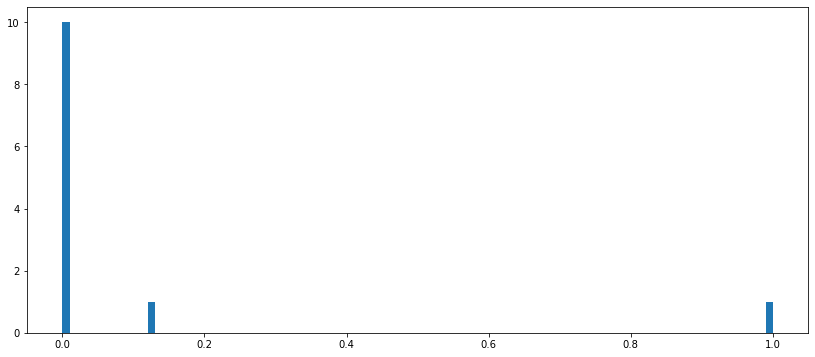

In [13]:
plt.figure(figsize=(14,6))
_ = plt.hist(nunique.astype(float)/train.shape[0], bins=100)

In [14]:
mask = (nunique.astype(float)/train.shape[0] > 0.1)
train.loc[:, mask]

,id,Annual_Premium
0,1,40454.0
1,2,33536.0
2,3,38294.0
3,4,28619.0
4,5,27496.0
...,...,...
381104,381105,30170.0
381105,381106,40016.0
381106,381107,35118.0
381107,381108,44617.0


In [15]:
train['Annual_Premium'].value_counts()

2630.0     64877
69856.0      140
39008.0       41
38287.0       38
45179.0       38
           ...  
62326.0        1
59733.0        1
55934.0        1
75387.0        1
53346.0        1
Name: Annual_Premium, Length: 48838, dtype: int64

In [76]:
cat_cols = list(train.select_dtypes(include=['object']).columns)
num_cols = list(train.select_dtypes(exclude=['object']).columns)

<AxesSubplot:>

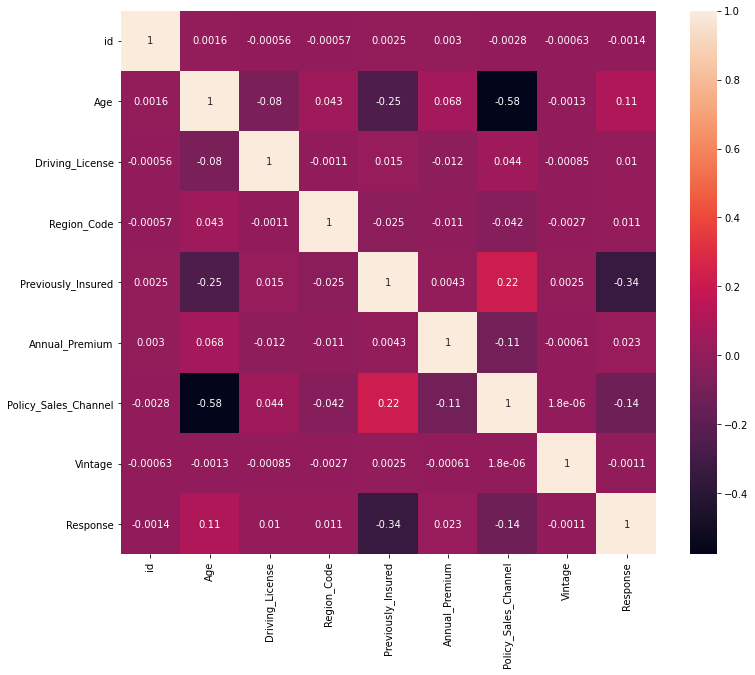

In [40]:
plt.figure(figsize=(12,10))
seaborn.heatmap(train.corr(), annot = True)

In [69]:
train.loc[:,cat_cols].head().T

,0,1,2,3,4
Gender,Male,Male,Male,Male,Female
Vehicle_Age,> 2 Years,1-2 Year,> 2 Years,< 1 Year,< 1 Year
Vehicle_Damage,Yes,No,Yes,No,No


In [77]:
num_cols.remove('Response')

In [78]:
categorical_train = train[cat_cols]
categorical_test = test[cat_cols]

In [79]:
numerical_train = train[num_cols]
numerical_test = test[num_cols]

In [80]:
from collections import defaultdict

d = defaultdict(LabelEncoder)

categorical_train = categorical_train.apply(lambda x: d[x.name].fit_transform(x))
categorical_test = categorical_test.apply(lambda x: d[x.name].transform(x))

In [84]:
X = pd.concat([categorical_train, numerical_train], axis=1)

In [83]:
y = train['Response']

In [85]:
X_test = pd.concat([categorical_test, numerical_test], axis=1)

In [86]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

In [109]:
from lightgbm import LGBMClassifier

gbm = LGBMClassifier(class_weight = 'balanced')

parameters_lgbm = {'learning_rate':(0.1,0.01), 'n_estimators':range(40,600,10),
                'max_depth':range(2,12,2),
              }

clf_lgbm = RandomizedSearchCV(gbm, parameters_lgbm, random_state=0, cv=4)

clf_lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=4, estimator=LGBMRegressor(class_weight='balanced'),
                   param_distributions={'learning_rate': (0.1, 0.01),
                                        'max_depth': range(2, 12, 2),
                                        'n_estimators': range(40, 600, 10)},
                   random_state=0)

In [110]:
y_pred_lgbm = clf_lgbm.predict(X_valid)

In [111]:
average_precision_score(y_valid, y_pred_lgbm), roc_auc_score(y_valid, y_pred_lgbm)

(0.37345744179592544, 0.8589734058054892)

In [112]:
y_pred_lgbm

array([ 0.00103573,  0.70963238,  0.76412483, ..., -0.00533788,
       -0.0052737 ,  0.72997586])

<AxesSubplot:>

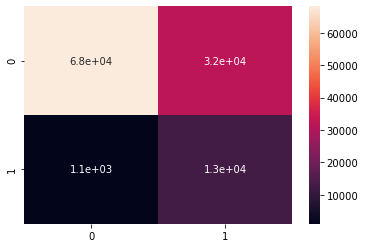

In [113]:
seaborn.heatmap(confusion_matrix(y_valid, y_pred_lgbm.round()), annot=True)

In [114]:
print(classification_report(y_valid, y_pred_lgbm.round()))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80    100195
           1       0.29      0.92      0.44     14138

    accuracy                           0.71    114333
   macro avg       0.64      0.80      0.62    114333
weighted avg       0.90      0.71      0.76    114333

